In [1]:
from aaff import aaff,alc_deriv_grad_nuc,alc_differential_grad_nuc
from berny import Berny, geomlib, coords,Geometry,Math
from pyscf import gto,scf
import numpy as np 
from numpy.linalg import norm as norm
import matplotlib.pyplot as plt
from pyscf.grad import rhf as grhf
from pyscf.hessian import rhf as hrhf
import basis_set_exchange as bse
from pyscf.geomopt.berny_solver import optimize
from scipy.interpolate import spline
ang2bohr=1.8897261246
bohr2ang=.5291772109
%load_ext autoreload
%autoreload 2

In [163]:
import sys
sys.path.append( '/home/administrator/Documenti/APDFT/prototyping/hessian/AAFF/Libs')
from Morse import Morse_interpolator,harm_freq
from FDcoeffs import *
from FcMole import FcM,FcM_like

In [108]:
import pyscf.data

In [114]:
print(dir(pyscf.data.elements))

['ATOMIC_NAMES', 'CONFIGURATION', 'ELEMENTS', 'ELEMENTS_PROTON', 'ISOTOPE_MAIN', 'MASSES', 'NRSRHF_CONFIGURATION', 'NUC', 'N_CORE_SHELLS', 'N_CORE_VALENCE_SHELLS', '_ELEMENTS_UPPER', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_atom_symbol', '_rm_digit', '_std_symbol', '_std_symbol_without_ghost', '_symbol', 'charge', 'is_ghost_atom', 'numpy', 'unicode']


In [3]:
def mpa(g,h,R0,De): # Morse Potential Approximation
    Z=g**2/(2*De)/h
    for i in range(3):
        t=float(np.roots([1,-2,1-2*Z,+Z])[i])
        a=g/(2*De)/(t*(1-t))
        dX=np.log(t)/a
        if a>0 and t>0:
            return R0+dX
    return -1

In [4]:
def bernyopt(name,mol):
    geom=Geometry([name[0],name[1]],mol.atom_coords()*bohr2ang)
    return Berny(geom)

In [5]:
def appHess(name,mol):
    return bernyopt(name,mol)._state.H[0,0]

In [6]:
co_min=(2.08272, -112.78661621869807)
nn_min=(2.01389, -108.98906407528155)
bf_min=(2.35348, -124.16243198073053)
pcx2=bse.get_basis("pcX-2",fmt="nwchem",elements=[5,6,7,8,9])

In [7]:
CO=gto.M(atom="C 0 0 0; O 0 0 2.08272",unit="Bohr",basis=pcx2)
NN=gto.M(atom="N 0 0 0; N 0 0 2.01389",unit="Bohr",basis=pcx2)
BF=gto.M(atom="B 0 0 0; F 0 0 2.35348",unit="Bohr",basis=pcx2)

In [8]:
COhf=scf.RHF(CO)
NNhf=scf.RHF(NN)
BFhf=scf.RHF(BF)
COhf.scf()
NNhf.scf()
BFhf.scf()

converged SCF energy = -112.786616218695
converged SCF energy = -108.989064075281
converged SCF energy = -124.162431980726


-124.16243198072553

In [9]:
dm01=COhf.make_rdm1()
COscanpts=np.linspace(1.8,2.6,31)
COscan=[]
for x in COscanpts:
    mol=gto.M(atom="C 0 0 0; O 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
    mf=scf.RHF(mol)
    COscan.append(mf.scf(dm0=dm01))
    dm01=mf.make_rdm1()

In [10]:
dm01=BFhf.make_rdm1()
BFscanpts=np.linspace(2.,2.8,31)
BFscan=[]
for x in BFscanpts:
    mol=gto.M(atom="B 0 0 0; F 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
    mf=scf.RHF(mol)
    BFscan.append(mf.scf(dm0=dm01))
    dm01=mf.make_rdm1()

In [11]:
dm01=NNhf.make_rdm1()
NNscanpts=np.linspace(1.7,2.4,31)
NNscan=[]
for x in NNscanpts:
    mol=gto.M(atom="N 0 0 0; N 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
    mf=scf.RHF(mol)
    NNscan.append(mf.scf(dm0=dm01))
    dm01=mf.make_rdm1()

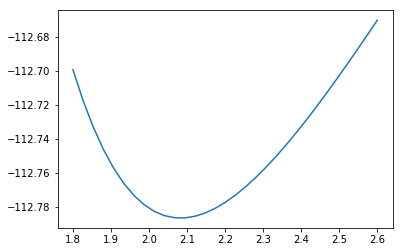

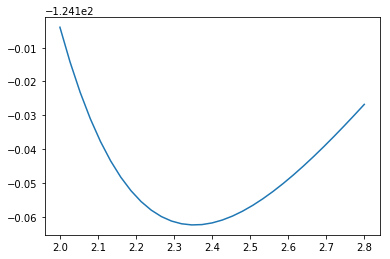

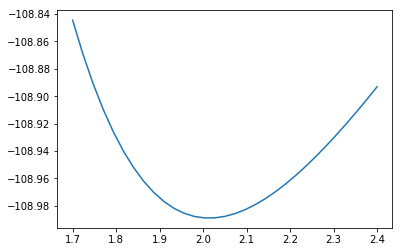

In [12]:
plt.plot(COscanpts,COscan)
plt.show()
plt.plot(BFscanpts,BFscan)
plt.show()
plt.plot(NNscanpts,NNscan)

In [13]:
def e_scan(mol,np):
    if mol=="CO": return spline(COscanpts,COscan,np)
    if mol=="BF": return spline(BFscanpts,BFscan,np)
    if mol=="NN": return spline(NNscanpts,NNscan,np)

In [14]:
spline(COscanpts,COscan,2.3)

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """Entry point for launching an IPython kernel.


array(-112.75844033)

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


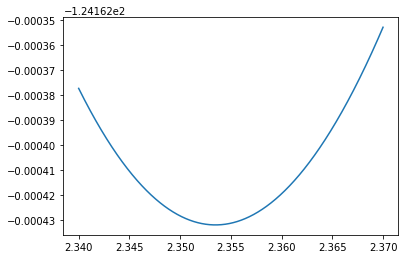

In [15]:
xp=np.linspace(2.34,2.37,1001)
plt.plot(xp,e_scan("BF",xp))

In [16]:
at_en={"B":scf.RHF(gto.M(atom="B 0 0 0",spin=1,basis=pcx2)).scf(),\
       "C":scf.RHF(gto.M(atom="C 0 0 0",basis=pcx2)).scf(),\
       "N":scf.RHF(gto.M(atom="N 0 0 0",spin=1,basis=pcx2)).scf(),\
       "O":scf.RHF(gto.M(atom="O 0 0 0",basis=pcx2)).scf(),\
       "F":scf.RHF(gto.M(atom="F 0 0 0",spin=1,basis=pcx2)).scf()
      }

converged SCF energy = -24.5281859226591
converged SCF energy = -37.6029290136078
converged SCF energy = -54.2616567416514
converged SCF energy = -74.6877238559481
converged SCF energy = -99.4065434956607


In [17]:
apbf=APDFT_perturbator(BFhf,sites=[0,1])
apbf.build_all()
apco=APDFT_perturbator(COhf,sites=[0,1])
apco.build_all()
apnn=APDFT_perturbator(NNhf,sites=[0,1])
apnn.build_all()

In [18]:
apco.APDFT3(np.asarray([-1,1]))

-124.12995954395484

In [19]:
bde={"bf":at_en["B"]+at_en["F"]-apco.APDFT3(np.asarray([-1,1])),\
    "co_bf":at_en["C"]+at_en["O"]-apbf.APDFT3(np.asarray([1,-1])),\
    "co_nn":at_en["C"]+at_en["O"]-apnn.APDFT3(np.asarray([-1,1])),\
    "nn":2*at_en["N"]-apco.APDFT3(np.asarray([1,-1]))\
}

In [20]:
bde

{'bf': 0.1952301256350779,
 'co_bf': 0.4527514644498183,
 'co_nn': 0.49129375595794045,
 'nn': 0.46642394996948155}

In [21]:
# derivatives of the gradient and the hessian from af and FD
dl=0.1
c5=get_coeffs(5)
def hoad(mol):
    afs=[]
    hs=[]
    for i in range(-2,3):
        mol1=FcM_like(mol,fcs=[i*dl,-i*dl])
        mf=scf.RHF(mol1)
        mf.scf(dm0=mf.init_guess_by_1e())
        afs.append(aaff(mf,[1,-1])[1,2])
        hs.append(mf.Hessian().hess()[1,1,2,2])
    gders=[afs[2],c5[1].dot(afs)/dl,c5[2].dot(afs)/dl**2,c5[3].dot(afs)/dl**3,c5[4].dot(afs)/dl**4]
    hders=[hs[2],c5[1].dot(hs)/dl,c5[2].dot(hs)/dl**2,c5[3].dot(hs)/dl**3,c5[4].dot(hs)/dl**4]
    return np.asarray(gders),np.asarray(hders)

In [22]:
#gderCO,hderCO=hoad(CO)
#gderBF,hderBF=hoad(BF)
#gderNN,hderNN=hoad(NN)
#np.save("./Diatomics_derivs",np.asarray([gderCO,hderCO,gderBF,hderBF,gderNN,hderNN]))

In [23]:
gderCO=np.load("./Diatomics_derivs.npy")[0]
hderCO=np.load("./Diatomics_derivs.npy")[1]
gderBF=np.load("./Diatomics_derivs.npy")[2]
hderBF=np.load("./Diatomics_derivs.npy")[3]
gderNN=np.load("./Diatomics_derivs.npy")[4]
hderNN=np.load("./Diatomics_derivs.npy")[5]

In [24]:
gpNN=gderCO[0]+gderCO[1]/2+gderCO[2]/6+gderCO[3]/24+gderCO[4]/120+alc_differential_grad_nuc(CO,[1,-1])[1,2]
hpNN=hderCO[0]+hderCO[1]+hderCO[2]/2+hderCO[3]/6+hderCO[4]/24

In [25]:
gpco_nn=[gderCO[0]+alc_deriv_grad_nuc(CO,[1,-1])[1,2],
        gderCO[0]+gderCO[1]/2+alc_differential_grad_nuc(CO,[1,-1])[1,2],
         gderCO[0]+gderCO[1]/2+gderCO[2]/6+alc_differential_grad_nuc(CO,[1,-1])[1,2],
        gderCO[0]+gderCO[1]/2+gderCO[2]/6+gderCO[3]/24+alc_differential_grad_nuc(CO,[1,-1])[1,2],
        gderCO[0]+gderCO[1]/2+gderCO[2]/6+gderCO[3]/24+gderCO[4]/120+alc_differential_grad_nuc(CO,[1,-1])[1,2]]

In [26]:
hpco_nn=[hderCO[0],
         hderCO[0]+hderCO[1],
         hderCO[0]+hderCO[1]+hderCO[2]/2,
         hderCO[0]+hderCO[1]+hderCO[2]/2+hderCO[3]/6,
         hderCO[0]+hderCO[1]+hderCO[2]/2+hderCO[3]/6+hderCO[4]/24]

In [27]:
gpBF=-gderCO[0]+gderCO[1]/2-gderCO[2]/6+gderCO[3]/24-gderCO[4]/120+alc_differential_grad_nuc(CO,[-1,1])[1,2]
hpBF=hderCO[0]-hderCO[1]+hderCO[2]/2-hderCO[3]/6+hderCO[4]/24

In [28]:
gpco_bf=[-gderCO[0]+alc_deriv_grad_nuc(CO,[-1,1])[1,2],
    -gderCO[0]+gderCO[1]/2+alc_differential_grad_nuc(CO,[-1,1])[1,2],
    -gderCO[0]+gderCO[1]/2-gderCO[2]/6+alc_differential_grad_nuc(CO,[-1,1])[1,2],
    -gderCO[0]+gderCO[1]/2-gderCO[2]/6+gderCO[3]/24+alc_differential_grad_nuc(CO,[-1,1])[1,2],
    -gderCO[0]+gderCO[1]/2-gderCO[2]/6+gderCO[3]/24-gderCO[4]/120+alc_differential_grad_nuc(CO,[-1,1])[1,2]]

In [29]:
hpco_bf=[hderCO[0],
         hderCO[0]-hderCO[1],
         hderCO[0]-hderCO[1]+hderCO[2]/2,
         hderCO[0]-hderCO[1]+hderCO[2]/2-hderCO[3]/6,
         hderCO[0]-hderCO[1]+hderCO[2]/2-hderCO[3]/6+hderCO[4]/24]

In [30]:
miNN=Morse_interpolator(gpNN,hpNN,co_min[0],bde["nn"]+gpNN**2/hpNN/2,apco.APDFT3(np.asarray([1,-1])))
miNN.minimum(),nn_min,\
co_min[0]-gpNN/hpNN,apco.APDFT3(np.asarray([1,-1]))-gpNN**2/hpNN/2
miBF=Morse_interpolator(gpco_bf[3],hpco_bf[4],co_min[0],bde["bf"]+gpBF**2/hpBF/2,apco.APDFT3(np.asarray([-1,1])))
miBF.minimum(),bf_min,(co_min[0]-gpBF/hpBF,apco.APDFT3(np.asarray([-1,1]))-gpBF**2/hpBF/2,apco.APDFT3(np.asarray([-1,1])))

((2.3408858228082465, -124.15931999267524),
 (2.35348, -124.16243198073053),
 (2.25880033925587, -124.15343476073394, -124.12995954395484))

In [31]:
gpbf_co=[gderBF[0]+alc_deriv_grad_nuc(BF,[1,-1])[1,2],
         gderBF[0]+gderBF[1]/2+alc_differential_grad_nuc(BF,[1,-1])[1,2],
         gderBF[0]+gderBF[1]/2+gderBF[2]/6+alc_differential_grad_nuc(BF,[1,-1])[1,2],
         gderBF[0]+gderBF[1]/2+gderBF[2]/6+gderBF[3]/24+alc_differential_grad_nuc(BF,[1,-1])[1,2],
         gderBF[0]+gderBF[1]/2+gderBF[2]/6+gderBF[3]/24+gderBF[4]/120+alc_differential_grad_nuc(BF,[1,-1])[1,2]]

In [32]:
hpbf_co=[hderBF[0],
         hderBF[0]+hderBF[1],
         hderBF[0]+hderBF[1]+hderBF[2]/2,
         hderBF[0]+hderBF[1]+hderBF[2]/2+hderBF[3]/6,
         hderBF[0]+hderBF[1]+hderBF[2]/2+hderBF[3]/6+hderBF[4]/24]

In [33]:
gpNNco=gderNN[0]+gderNN[1]/2+gderNN[2]/6+gderNN[3]/24+gderNN[4]/120+alc_differential_grad_nuc(NN,[1,-1])[1,2]
hpNNco=hderNN[0]+hderNN[1]+hderNN[2]/2+hderNN[3]/6+hderNN[4]/24

In [34]:
gpnn_co=[gderNN[0]+alc_deriv_grad_nuc(NN,[1,-1])[1,2],
         gderNN[0]+gderNN[1]/2+alc_differential_grad_nuc(NN,[1,-1])[1,2],
         gderNN[0]+gderNN[1]/2+gderNN[2]/6+alc_differential_grad_nuc(NN,[1,-1])[1,2],
         gderNN[0]+gderNN[1]/2+gderNN[2]/6+gderNN[3]/24+alc_differential_grad_nuc(NN,[1,-1])[1,2],
         gderNN[0]+gderNN[1]/2+gderNN[2]/6+gderNN[3]/24+gderNN[4]/120+alc_differential_grad_nuc(NN,[1,-1])[1,2]]

In [35]:
hpnn_co=[hderNN[0],
         hderNN[0]+hderNN[1],
         hderNN[0]+hderNN[1]+hderNN[2]/2,
         hderNN[0]+hderNN[1]+hderNN[2]/2+hderNN[3]/6,
         hderNN[0]+hderNN[1]+hderNN[2]/2+hderNN[3]/6+hderNN[4]/24]

In [37]:
miNNco=Morse_interpolator(gpNNco,hpNNco,nn_min[0],bde["co_nn"],apnn.APDFT3(np.asarray([1,-1])))
miNNco.minimum(),co_min

((2.084176625558622, -112.78602030389449), (2.08272, -112.78661621869807))

In [38]:
mpa(gpNNco,hpNNco,nn_min[0],.49),nn_min[0]-gpNNco/hpNNco,co_min[0]

(2.084187364659855, 2.0760160041655045, 2.08272)

In [39]:
nn_min[1]-2*scf.RHF(gto.M(atom="N 0 0 0",spin=3,basis=pcx2)).scf()

converged SCF energy = -54.3987703681837


-0.19152333891423723

In [40]:
bde

{'bf': 0.1952301256350779,
 'co_bf': 0.4527514644498183,
 'co_nn': 0.49129375595794045,
 'nn': 0.46642394996948155}

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  after removing the cwd from sys.path.


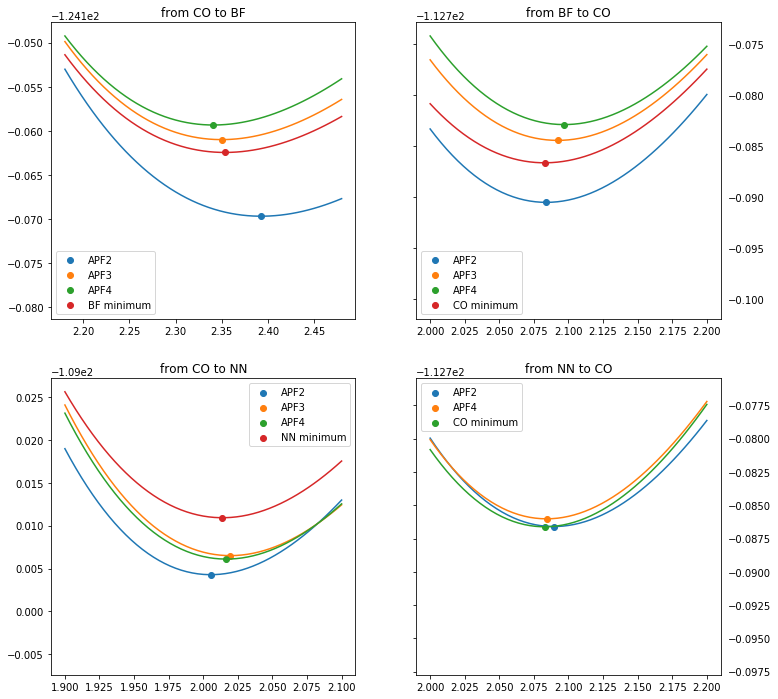

In [49]:
fig, ((ax1, ax2), (ax3, ax4)) =plt.subplots(2,2,figsize=(12,12))
lss=["--",":",]
ax1.set_title("from CO to BF")
scan=np.linspace(2.18,2.48,51)
for i in range(1,4):
    mi = Morse_interpolator(gpco_bf[i],hpco_bf[i+1],co_min[0],bde["bf"]+gpco_bf[i]**2/2/hpco_bf[i]\
                            ,apco.APDFT3(np.asarray([-1,1])))
    ax1.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax1.plot(scan,mi.E(scan))
ax1.scatter(*bf_min,label="BF minimum")
ax1.plot(scan,e_scan("BF",scan))
ax1.legend()
#ax1.set_xlim(2.25,2.4)
#ax1.set_ylim(ax1.get_ylim()[0]+0.009,ax1.get_ylim()[1]-0.008)
#print(dir(ax1))
#############################
ax2.set_title("from BF to CO")
ax2.yaxis.set_tick_params(labelleft=False,labelright=True)
scan=np.linspace(2.0,2.2,51)
for i in range(1,4):
    mi = Morse_interpolator(gpbf_co[i],hpbf_co[i+1],bf_min[0],bde["co_bf"]+gpbf_co[i]**2/2/hpbf_co[i],apbf.APDFT3(np.asarray([1,-1])))
    ax2.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax2.plot(scan,mi.E(scan))
ax2.scatter(*co_min,label="CO minimum")
ax2.plot(scan,e_scan("CO",scan))
ax2.legend() 
###############################
ax3.set_title("from CO to NN")
scan=np.linspace(1.9,2.1,51)
for i in range(1,4):
    mi = Morse_interpolator(gpco_nn[i],hpco_nn[i+1],co_min[0],bde["nn"]+gpco_nn[i]**2/2/hpco_nn[i],apco.APDFT3(np.asarray([1,-1])))
    ax3.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax3.plot(scan,mi.E(scan))
ax3.scatter(*nn_min,label="NN minimum")
ax3.plot(scan,e_scan("NN",scan))
ax3.legend() 
##############################
ax4.set_title("from NN to CO")
ax4.yaxis.set_tick_params(labelleft=False,labelright=True)
scan=np.linspace(2.0,2.2,51)
for i in [1,3]:
    mi = Morse_interpolator(gpnn_co[i],hpnn_co[i+1],nn_min[0],bde["co_nn"]+gpnn_co[i]**2/2/hpnn_co[i],apnn.APDFT3(np.asarray([-1,1])))
    ax4.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax4.plot(scan,mi.E(scan))
ax4.scatter(*co_min,label="CO minimum")
ax4.plot(scan,e_scan("CO",scan))
ax4.legend()
#plt.savefig("diatomics.png",bbox_inches="tight")

In [46]:
scanpts2=np.linspace(1.7,2.8,31)
#NNscan2=[]
#COscan2=[]
#BFscan2=[]
#for x in scanpts2:
#    mol=gto.M(atom="N 0 0 0; N 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
#    mf=scf.RHF(mol)
#    NNscan2.append(mf.scf())
#    mol=gto.M(atom="C 0 0 0; O 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
#    mf=scf.RHF(mol)
#    COscan2.append(mf.scf())
#    mol=gto.M(atom="B 0 0 0; F 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
#    mf=scf.RHF(mol)
#    BFscan2.append(mf.scf())
#np.save("scan2diatomics",np.asarray([NNscan2,COscan2,BFscan2]))

In [47]:
NNscan2,COscan2,BFscan2=np.load("scan2diatomics.npy")

1550.447775327508 2406.9746499572184 1506.5153811794694
2525.509606971161 1418.0780489521078 2429.508265705918
2788.067152178234 2411.4181301563694 2730.3566784452223
morse 2394.1617514860427 NR 2739.6691755747547 target 2429.508265705918


Text(0.5, 1.0, 'APDFT3 with Morse potential fitting')

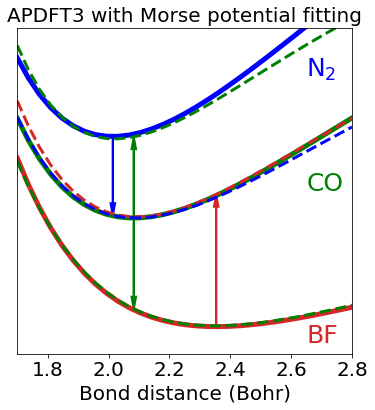

In [182]:
plt.figure(figsize=(6,6))
plt.plot(scanpts2,np.asarray(NNscan2)-min(NNscan2),lw=5,color="blue")
plt.plot(scanpts2,np.asarray(COscan2)-min(COscan2)-.15,lw=5,color="green")
plt.plot(scanpts2,np.asarray(BFscan2)-min(BFscan2)-.35,lw=5,color="C3")


i=2
#co->bf
mi = Morse_interpolator(gpco_bf[i],hpco_bf[i+1],co_min[0],bde["bf"]+gpco_bf[i]**2/2/hpco_bf[i+1]\
                        ,apco.APDFT3(np.asarray([-1,1]))-min(BFscan2)-.35)
print(mi.hfd(5,9),harm_freq(hpco_bf[i+1],5,9),harm_freq(hderBF[0],5,9))
plt.plot(scanpts2,mi.E(scanpts2),ls="--",lw=3,color="green")

#bf->co
mi = Morse_interpolator(gpbf_co[i],hpbf_co[i+1],bf_min[0],bde["co_bf"]+gpbf_co[i]**2/2/hpbf_co[i+1],\
                        apbf.APDFT3(np.asarray([1,-1]))-min(COscan2)-.15)
plt.plot(scanpts2,mi.E(scanpts2),ls="--",lw=3,color="C3")
print(mi.hfd(6,8),harm_freq(hpbf_co[i+1],6,8),harm_freq(hderCO[0],6,8))

#  co->nn
scan=np.linspace(1.9,2.1,51)
mi = Morse_interpolator(gpco_nn[i],hpco_nn[i+1],co_min[0],bde["nn"]+gpco_nn[i]**2/2/hpco_nn[i],\
                        apco.APDFT3(np.asarray([1,-1]))-min(NNscan2))
#plt.scatter(*mi.minimum(),label="APF{}".format(i+1))
plt.plot(scanpts2,mi.E(scanpts2),ls="--",lw=3,color="green")
print(mi.hfd(7,7),harm_freq(hpco_nn[i+1],7,7),harm_freq(hderNN[0],7,7))

# nn->co
mi = Morse_interpolator(gpnn_co[i],hpnn_co[i+1],nn_min[0],bde["co_nn"]+gpnn_co[i]**2/2/hpnn_co[i+1],\
                        apnn.APDFT3(np.asarray([-1,1]))-min(COscan2)-.15)
#plt.scatter(*mi.minimum(),label="APF{}".format(i+1))
plt.plot(scanpts2,mi.E(scanpts2),ls="--",lw=3,color="blue")
print("morse",mi.hfd(6,8),"NR",harm_freq(hpnn_co[i+1],6,8),"target",harm_freq(hderCO[0],6,8))


plt.arrow(co_min[0],-.15,0,apco.APDFT3(np.asarray([-1,1]))-min(BFscan2)-.2 ,length_includes_head=True,\
          color="green",lw=2,head_width=.015)
plt.arrow(co_min[0],-.15,0,apco.APDFT3(np.asarray([1,-1]))-min(NNscan2)+.15 ,length_includes_head=True,\
          color="green",lw=2,head_width=.015)

plt.arrow(nn_min[0],0.,0,apnn.APDFT3(np.asarray([1,-1]))-min(COscan2)-.15 ,length_includes_head=True,\
          color="blue",lw=2,head_width=.015)

plt.arrow(bf_min[0],-.35,0,apbf.APDFT3(np.asarray([1,-1]))-min(COscan2)+.2 ,length_includes_head=True,\
          color="C3",lw=2,head_width=.015)

plt.xlim(1.7,2.8)
plt.ylim(-0.4,0.2)
plt.text(2.65,0.11,"N$_2$",size=25,color="blue")
plt.text(2.65,-.1,"CO",size=25,color="green")
plt.text(2.65,-.38,"BF",size=25,color="C3")
plt.yticks([])
plt.xticks(size=20)
plt.xlabel("Bond distance (Bohr)",size=20)
plt.title("APDFT3 with Morse potential fitting",size=20)

In [167]:
vars(mi)

{'R0': 2.35348,
 'De': 0.5203457092805767,
 're': 2.092151773801715,
 'a': 1.261025243935556,
 'e0': -0.10698931238916884,
 'e_min': -0.14800224805703852}

In [157]:
mi.e0

-0.145531603897291

In [164]:
harm_freq(hderCO[0],6,8)

2429.508265705918